In [1]:
######################### Initialize #################################
import pyspark
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import desc

from collections import namedtuple
import time
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 

In [2]:
######################## Setup Spark ################################
sc = SparkContext('local[*]')
ssc = StreamingContext(sc, 10 )
# Allow to use the SQL context
sqlContext = SQLContext(sc)
socket_stream = ssc.socketTextStream("twitter-stream", 5555)

In [3]:
# Setup Socket stream
lines = socket_stream.window( 20 )

# Want to do a count of each hashtag
fields = ("tag", "count" )
Tweet = namedtuple( 'Tweet', fields )

# Use Parenthesis for multiple lines or use \.
( lines.flatMap( lambda text: text.split( " " ) ) #Splits to a list
  .filter( lambda word: word.lower().startswith("#") ) # Checks for hashtag calls
  .map( lambda word: ( word.lower(), 1 ) ) # Lower cases the word
  .reduceByKey( lambda a, b: a + b ) # Reduces
  .map( lambda rec: Tweet( rec[0], rec[1] ) ) # Stores in a Tweet Object
  .foreachRDD( lambda rdd: rdd.toDF().sort( desc("count") ) # Sorts Them in a DF
  .limit(10).registerTempTable("tweets") ) ) # Registers to a table.

In [4]:
# Start the Stream
ssc.start() 

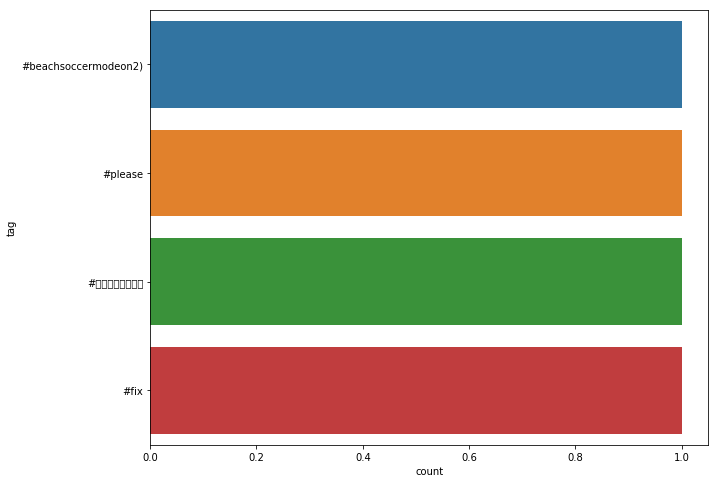

In [5]:
######################## Execute #################################
# Create the plot
count = 0
while count < 10:
    
    time.sleep( 3 )
    top_10_tweets = sqlContext.sql( 'Select tag, count from tweets' )
    top_10_df = top_10_tweets.toPandas()
    display.clear_output(wait=True)
    plt.figure( figsize = ( 10, 8 ) )
    sns.barplot( x="count", y="tag", data=top_10_df)
    plt.show()
    count = count + 1